# Titanic - Machine Learning from Disaster

<img src="header.png" alt="Italian Trulli">

# Table of Contents

* [Introduction](#introduction)
* [House Keeping](#house)
* [Exploratory Data Analysis](#EDA)
* [Feature Selection](#feature)
* [Final Processing](#final)
* [Models](#model)
* [Model Tuning - Hyperparameter GridSearch](#tuning)
* [Model Performance](#performance)

# Introduction <a id="introduction"></a>

Analysis, Feature Engineering and Modelling of the titanic dataset from [Kaggle](https://www.kaggle.com/competitions/titanic/overview).

In this notebook is my first attempt of a thorough analysis of the titanic dataset. The goal was to predict survivors of the tragic sinking of the titanic based on various information such as age, sex and socio-economic status.

I tried several models, both with and without tuning to both improve my result and learn along the way.

**Best performing model: 83.4%**

**Hope you enjoy, let me know how I can improve, and if you liked it, an upvote would help me out alot!**

## Columns in the dataset

The columns present in the dataset are as follows: 
1. **PassengerId**: This column assigns a unique identifier for each passenger.
2. **Survived**: Specifies whether the given passenger survived or not (1 - survived, 0 - didn't survive)
3. **Pclass**: The passenger's class. (1 = Upper Deck, 2 = Middle Deck, 3 = Lower Deck)
4. **Name**: The name of the passenger. 
5. **Sex**: The sex of the passenger (male, female)
6. **Age**: The age of the passenger in years. If the age is estimated, is it in the form of xx.5. 
7. **SibSp**: How many siblings or spouses the passenger had on board with them. Sibling = brother, sister, stepbrother, stepsister and Spouse = husband, wife (mistresses and fianc√©s were ignored)
8. **Parch**: How many parents or children the passenger had on boad with them. Parent = mother and father, child = daughter, son, stepdaughter and stepson and some children travelled only with a nanny, therefore parch=0 for them.
9. **Ticket**: The ticket of the passenger. 
10. **Fare**: The fare amount paid by the passenger for the trip. 
11. **Cabin**: The cabin in which the passenger stayed. 
12. **Embarked**: The place from which the passenger embarked (S, C, Q)

# House Keeping <a id="house"></a>

## Import Libraries

In [82]:
from IPython.display import FileLink # add stuff to file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("YlGnBu")

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.metrics import classification_report

## Load Datasets

In [59]:
# load datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_gender_submission = pd.read_csv('gender_submission.csv')

# mark train and test sets for future split
df_train['train_test'] = 1
df_test['train_test'] = 0
df_test['Survived'] = np.NaN

#combine to a single dataframe with all data for feature engineering
df_all = pd.concat([df_train, df_test])

## First look at the 3 datasets

In [78]:
# train set

df_train.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  train_test  
0      0         A/5 21171   7.2500   NaN        S           1  
1      0          PC 17599  71.2833   C85        C           1  
2      0  STON/O2. 3101282   7.9250   NaN        S           1

In [79]:
# test set

df_test.head(3)

PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female  47.0      1   
2          894       2         Myles, Mr. Thomas Francis    male  62.0      0   

   Parch  Ticket    Fare Cabin Embarked  train_test  Survived  
0      0  330911  7.8292   NaN        Q           0       NaN  
1      0  363272  7.0000   NaN        S           0       NaN  
2      0  240276  9.6875   NaN        Q           0       NaN

In [80]:
# sample submission

df_gender_submission.head(3)

PassengerId  Survived
0          892         0
1          893         1
2          894         0

## Dataset summary

In [72]:
# train data
print(f'Loaded train dataset with shape {df_train.shape} ({df_train.shape[0]} rows and {df_train.shape[1]} columns) and column names: \n{df_train.columns.to_list()}')

# test data
print(f'\nLoaded test dataset with shape {df_test.shape} ({df_test.shape[0]} rows and {df_test.shape[1]} columns) and column names: \n{df_test.columns.to_list()}')

# sample submission data
print(f'\nLoaded sample submission dataset with shape {df_gender_submission.shape} ({df_gender_submission.shape[0]} rows and {df_gender_submission.shape[1]} columns) and column names: \n{df_gender_submission.columns.to_list()}')

Loaded train dataset with shape (891, 13) (891 rows and 13 columns) and column names: 
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test']

Loaded test dataset with shape (418, 13) (418 rows and 13 columns) and column names: 
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test', 'Survived']

Loaded sample submission dataset with shape (418, 2) (418 rows and 2 columns) and column names: 
['PassengerId', 'Survived']


## Train dataset

In [75]:
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  train_test  
0      0         A/5 21171   7.2500   NaN        S           1  
1      0          PC 17599  71.2833   C85        C           1  
2      0  STON/O2. 3101282   7.9250   NaN        S           1  
3      0            113803  53.1000  C123        S           1  
4      0            373450   8.0500   NaN        S           1

In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [9]:
df_train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  train_test  
count  891.000000  891.000000       891.0  
mean     0.381594   32.204208         1.0  
std      0.806057   49.693429         0.0  
min      0.000000    0.000000         1.0  
25%      0.000000    7.910400         1.0  
50%      0.000000   14.454200         1.0  
75%      0.000000   31.000000         1.0  
max      6.000000  512.329200         1.0

## Initial thoughs

* The **PassengerID** column shouldnt provide any useful information about survival, so it should be dropped.
* The **Fare** column looks very volatile on the high end, Q3 (75%) = 31 and MAX = 512, maybe outliers?
* There are null values in **Age**, **Cabin** and **Embarked**, these should be fixed, maybe **Age** and **Embarked** are missing data and **Cabin** is simply due to not every passenger having a **Cabin**
* Both numerical and categorical columns. They should be examined further and either scaled or one hot encoded to improve model performance

# Exploratory Data Analysis <a id="EDA"></a>

## Survival ratio

There were 342 survivors and 549 mortalities in the train set.
Making the chance of survival 38.38383838383838%


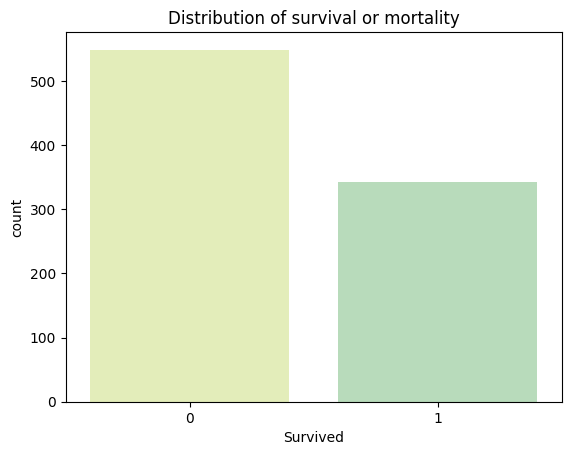

In [10]:
df_survived = df_train['Survived']

print(f'There were {df_survived.value_counts()[1]} survivors and {df_survived.value_counts()[0]} mortalities in the train set.')
print(f'Making the chance of survival {df_survived.value_counts()[1] / (df_survived.value_counts()[1] + df_survived.value_counts()[0]) * 100}%')

sns.countplot(x = df_survived)
plt.title('Distribution of survival or mortality')
plt.show()

## Name

In [11]:
# Extract titles

df_train['Title'] = df_train['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

#df_train['Title'] = df_train['Title'].str.split('.', expand=True)[0]

#df_train['Title'] = df_train['Title'].astype('string')

# List most frequent titles

titles = df_train['Title'].value_counts()[0:6]

print(titles)

for title in ['Mr']:
    print(f"Survival ratio for {title}: {df_train[df_train['Title'] == title]['Survived'].mean()}")

 Mr        517
 Miss      182
 Mrs       125
 Master     40
 Dr          7
 Rev         6
Name: Title, dtype: int64
Survival ratio for Mr: nan


In [12]:
(df_train['Title'].value_counts()
                  .to_frame()
                  .reset_index()
                  .iloc[:6]
                  .rename(columns={'index':'Title', 'Title':'Frequency'}))

Title  Frequency
0       Mr        517
1     Miss        182
2      Mrs        125
3   Master         40
4       Dr          7
5      Rev          6

## Ticket Class

In [13]:
df_pclass = df_train['Pclass']

print('Passengers were split into three Ticket Classes and hereby the placement on the ship deck:')
print(f'There were {df_pclass.value_counts().sort_index()[1]} people on the upper deck.') 
print(f'There were {df_pclass.value_counts().sort_index()[2]} people on the middle deck.') 
print(f'There were {df_pclass.value_counts().sort_index()[3]} people on the lower deck')

sns.countplot(x = df_pclass)
plt.title('Distribution of ticket classes')
plt.show()

Passengers were split into three Ticket Classes and hereby the placement on the ship deck:
There were 216 people on the upper deck.
There were 184 people on the middle deck.
There were 491 people on the lower deck


## Passenger sex

There were 577 males aboard.
There were 314 females aboard.


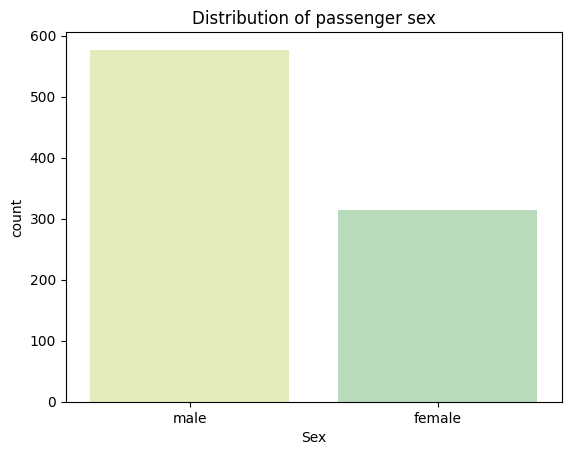

In [14]:
df_sex = df_train['Sex']
print(f'There were {df_sex.value_counts().sort_index()[1]} males aboard.') 
print(f'There were {df_sex.value_counts().sort_index()[0]} females aboard.') 

sns.countplot(x = df_sex)
plt.title('Distribution of passenger sex')
plt.show()

## Passenger age

In [15]:
df_age = df_train['Age']
print(f'There were {np.count_nonzero(df_age < 25)} passenges under the age of 25.') 
print(f'There were {np.count_nonzero((df_age >= 25) & (df_age <= 65))} passengers between the age of 25 and 65.') 
print(f'There were {np.count_nonzero(df_age > 65)} passenges older than 65.') 


sns.histplot(data = df_age)
plt.title('Distribution of passenger age')
plt.show()

There were 278 passenges under the age of 25.
There were 428 passengers between the age of 25 and 65.
There were 8 passenges older than 65.


## Number of siblings/spouses

There were 608 passengers with no siblings or spouses.


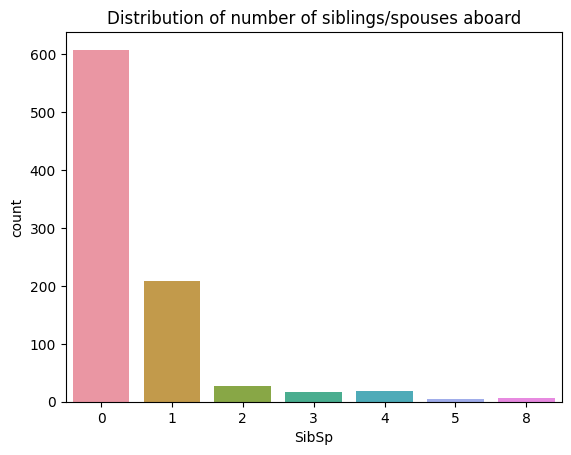

In [16]:
df_sibsp = df_train['SibSp']
print(f'There were {df_sibsp.value_counts().sort_index()[0]} passengers with no siblings or spouses.')

sns.countplot(x = df_sibsp)
plt.title('Distribution of number of siblings/spouses aboard')
plt.show()

## Number of parents/children

In [17]:
df_parch = df_train['Parch']
print(f'There were {df_parch.value_counts().sort_index()[0]} passengers with no parents or children.')

sns.countplot(x = df_parch)
plt.title('Distribution of number of parents/children aboard')
plt.show()

There were 678 passengers with no parents or children.


## Tickets

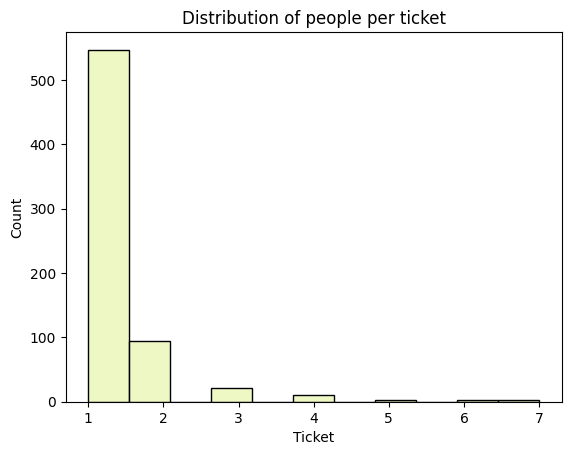

In [18]:
df_ticket = df_train['Ticket']
#print(f'There were {np.count_nonzero(df_fare < 10)} passengers payed less than 10 dollars for their ticket.') 
#print(f'There were {np.count_nonzero((df_fare >= 10) & (df_fare <= 50))} passengers payed between 10 and 50 dollars for their ticket.') 
#print(f'There were {np.count_nonzero(df_fare > 50)} passengers payed more than 50 dollars for their ticket.') 


sns.histplot(data = df_ticket.value_counts())
plt.title('Distribution of people per ticket')
plt.show()

## Fare

In [19]:
df_fare = df_train['Fare']
print(f'There were {np.count_nonzero(df_fare < 10)} passengers payed less than 10 dollars for their ticket.') 
print(f'There were {np.count_nonzero((df_fare >= 10) & (df_fare <= 50))} passengers payed between 10 and 50 dollars for their ticket.') 
print(f'There were {np.count_nonzero(df_fare > 50)} passengers payed more than 50 dollars for their ticket.') 


sns.histplot(data = df_fare)
plt.title('Distribution of fares')
plt.show()

There were 336 passengers payed less than 10 dollars for their ticket.
There were 395 passengers payed between 10 and 50 dollars for their ticket.
There were 160 passengers payed more than 50 dollars for their ticket.


## Cabin

There were 204 passengers who had a cabin.
There were 687 passengers who did not have a cabin.


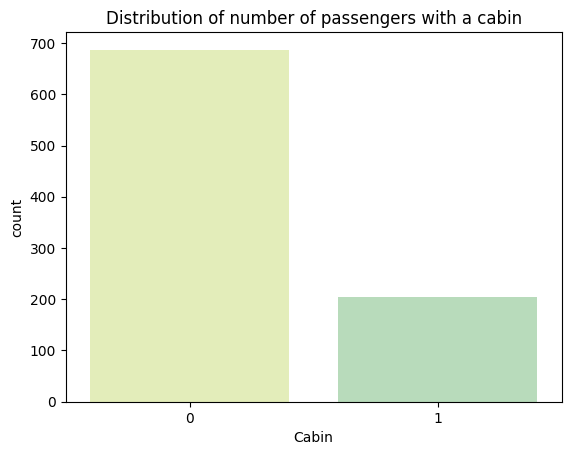

In [20]:
df_cabin = df_train['Cabin']
df_cabin = df_cabin.apply(lambda x: 1 if not pd.isnull(x) else 0)
print(f'There were {df_cabin.value_counts().sort_index()[1]} passengers who had a cabin.') 
print(f'There were {df_cabin.value_counts().sort_index()[0]} passengers who did not have a cabin.') 

sns.countplot(x = df_cabin)
plt.title('Distribution of number of passengers with a cabin')
plt.show()

## Port of Embarkation

In [21]:
df_port = df_train['Embarked']
print(f'There were {df_port.value_counts().sort_index()[2]} passengers boarding the ship at Southampton.') 
print(f'There were {df_port.value_counts().sort_index()[0]} passengers boarding the ship at Cherbourg.') 
print(f'There were {df_port.value_counts().sort_index()[1]} passengers boarding the ship at Queenstown.') 

sns.countplot(x = df_port)
plt.title('Distribution of number of passengers with a cabin')
plt.show()

There were 644 passengers boarding the ship at Southampton.
There were 168 passengers boarding the ship at Cherbourg.
There were 77 passengers boarding the ship at Queenstown.


## Survival rate factors

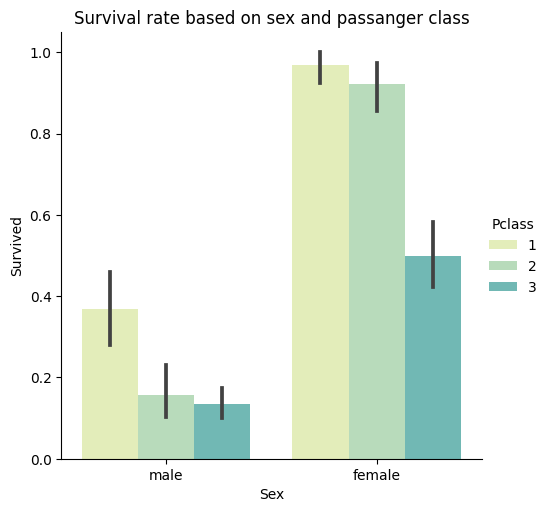

In [22]:
sns.catplot(data=df_train, x="Sex", y="Survived", hue="Pclass", kind="bar")
plt.title('Survival rate based on sex and passanger class')
plt.show()

# Feature Selection <a id="feature"></a>

In [23]:
# change cabin names and numbers to cabin yes or no

df_train['Cabin'] = df_train['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# change male/female to 0 and 1

df_train.loc[df_train['Sex'] == 'male', 'Sex'] = 0
df_train.loc[df_train['Sex'] == 'female', 'Sex'] = 1

# One-Hot encode Embarkation (done with pd.get_dummies() further down)

df_train.loc[df_train['Embarked'] == 'S', 'embarked_Southampton'] = 1
df_train.loc[df_train['Embarked'] == 'C', 'embarked_Cherbough'] = 1
df_train.loc[df_train['Embarked'] == 'Q', 'embarked_Queenstown'] = 1

df_train = df_train.drop('Embarked', axis = 1)

df_train = df_train.replace(np.nan, 0)

In [24]:
# Corelation matrix of numerical categories
(df_train[[
    'PassengerId', 
    'Survived', 
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Cabin',
    'Pclass',
    'embarked_Southampton',
    'embarked_Cherbough',
    'embarked_Queenstown']].corr())

PassengerId  Survived       Age     SibSp     Parch  \
PassengerId              1.000000 -0.005007  0.038125 -0.057527 -0.001652   
Survived                -0.005007  1.000000  0.010539 -0.035322  0.081629   
Age                      0.038125  0.010539  1.000000 -0.184664 -0.048786   
SibSp                   -0.057527 -0.035322 -0.184664  1.000000  0.414838   
Parch                   -0.001652  0.081629 -0.048786  0.414838  1.000000   
Fare                     0.012658  0.257307  0.135516  0.159651  0.216225   
Cabin                    0.019919  0.316912  0.269360 -0.040460  0.036987   
Pclass                  -0.035144 -0.338481 -0.361353  0.083081  0.018443   
embarked_Southampton     0.022148 -0.155660  0.140578  0.070941  0.063036   
embarked_Cherbough      -0.001205  0.168240  0.001246 -0.059528 -0.011069   
embarked_Queenstown     -0.033606  0.003650 -0.237586 -0.026354 -0.081228   

                          Fare     Cabin    Pclass  embarked_Southampton  \
PassengerId           0.012658  0.019919 -0.035144              0.022148   
Survived              0.257307  0.316912 -0.338481             -0.155660   
Age                   0.135516  0.269360 -0.361353              0.140578   
SibSp                 0.159651 -0.040460  0.083081              0.070941   
Parch                 0.216225  0.036987  0.018443              0.063036   
Fare                  1.000000  0.482075 -0.549500             -0.166603   
Cabin                 0.482075  1.000000 -0.725541             -0.110087   
Pclass               -0.549500 -0.725541  1.000000              0.081720   
embarked_Southampton -0.166603 -0.110087  0.081720              1.000000   
embarked_Cherbough    0.269335  0.208528 -0.243292             -0.778359   
embarked_Queenstown  -0.117216 -0.129572  0.221009             -0.496624   

                      embarked_Cherbough  embarked_Queenstown  
PassengerId                    -0.001205            -0.033606  
Survived                        0.168240             0.003650  
Age                             0.001246            -0.237586  
SibSp                          -0.059528            -0.026354  
Parch                          -0.011069            -0.081228  
Fare                            0.269335            -0.117216  
Cabin                           0.208528            -0.129572  
Pclass                         -0.243292             0.221009  
embarked_Southampton           -0.778359            -0.496624  
embarked_Cherbough              1.000000            -0.148258  
embarked_Queenstown            -0.148258             1.000000

Text(0.5, 1.0, 'Heatmap for correlation between columns of training data')

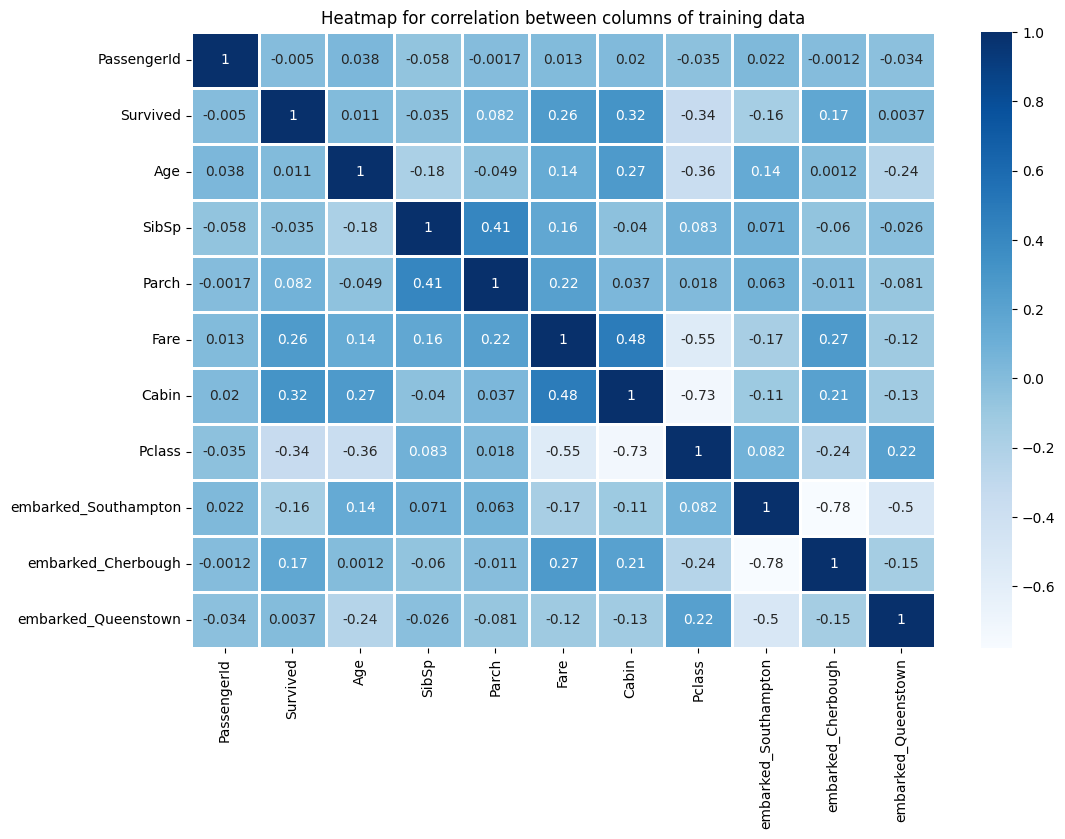

In [25]:
# Heatmap of correlation matrix for training data columns

fig, ax = plt.subplots(figsize=(12,8)) 

sns.heatmap((df_train[[
            'PassengerId', 
            'Survived', 
            'Age',
            'SibSp',
            'Parch',
            'Fare',
            'Cabin',
            'Pclass',
            'embarked_Southampton',
            'embarked_Cherbough',
            'embarked_Queenstown'
            ]].corr()),
            linewidths=1,
            cmap=plt.cm.Blues, 
            annot=True,
            ax=ax)

plt.title('Heatmap for correlation between columns of training data')

# Final Processing <a id="final"></a>

In [26]:
df_all.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  train_test  
0      0         A/5 21171   7.2500   NaN        S           1  
1      0          PC 17599  71.2833   C85        C           1  
2      0  STON/O2. 3101282   7.9250   NaN        S           1  
3      0            113803  53.1000  C123        S           1  
4      0            373450   8.0500   NaN        S           1

In [27]:
#impute nulls for continuous data 
df_all.Age = df_all.Age.fillna(df_train.Age.median())
df_all.Fare = df_all.Fare.fillna(df_train.Fare.median())

# drop null the two null Embarked values
df_all.dropna(subset=['Embarked'],inplace = True)

# change cabin names and numbers to cabin yes or no

df_all['Cabin'] = df_all['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# change male/female to 0 and 1

df_all.loc[df_all['Sex'] == 'male', 'Sex'] = 0
df_all.loc[df_all['Sex'] == 'female', 'Sex'] = 1

# extract titles

df_all['Title'] = df_all['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

df_all = (df_all.drop([
                    'PassengerId',
                    'Name',
                    'Title',
                    'Ticket',
                    'Name'],
                    axis = 1
                    ))

df_all['Pclass'] = df_all['Pclass'].astype(str)

df_all_dummies = pd.get_dummies(df_all[['Pclass', 
                                        'Sex', 
                                        'Age',
                                        'SibSp', 
                                        'Parch', 
                                        'Fare', 
                                        'Cabin', 
                                        'Embarked', 
                                        'train_test']])

# Scale data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
(df_all_dummies[['Age', 
                 'SibSp', 
                 'Parch', 
                 'Fare']]) = (scale.fit_transform(df_all_dummies[['Age', 
                                                                  'SibSp', 
                                                                  'Parch', 
                                                                  'Fare']]))

X_train = df_all_dummies[df_all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = df_all_dummies[df_all_dummies.train_test == 0].drop(['train_test'], axis =1)

y_train = df_all[df_all['train_test'] == 1]['Survived']
y_test = df_all[df_all['train_test'] == 0]['Survived']

print(f'{X_train.shape}, {X_test.shape}, {y_train.shape}')

(889, 13), (418, 13), (889,)


C:\Users\10122055\AppData\Local\Temp\ipykernel_10140\4201216275.py:32: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_all_dummies = pd.get_dummies(df_all[['Pclass',


# Models <a id="model"></a>

## Naive Bayes

In [28]:
gnb = GaussianNB()

cv = cross_val_score(gnb, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.74719101 0.74719101 0.7752809  0.79775281 0.78531073]
0.7705452929600711


In [29]:
lr = LogisticRegression(max_iter=2000)

cv = cross_val_score(lr, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.82022472 0.79775281 0.78651685 0.78089888 0.84180791]
0.8054402336062972


In [30]:
dt = tree.DecisionTreeClassifier(random_state=42)

cv = cross_val_score(dt, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.75280899 0.7752809  0.81460674 0.73033708 0.81920904]
0.7784485494826383


In [31]:
knn = KNeighborsClassifier()

cv = cross_val_score(knn, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.80337079 0.78089888 0.80898876 0.8258427  0.8079096 ]
0.805402145623056


In [32]:
rf = RandomForestClassifier(random_state=42)

cv = cross_val_score(rf, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.79775281 0.78651685 0.84831461 0.76404494 0.81920904]
0.8031676506062337


In [33]:
svc = SVC(probability=True)

cv = cross_val_score(svc, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.8258427  0.81460674 0.80337079 0.81460674 0.86440678]
0.8245667491906303


In [34]:
xgb = XGBClassifier(random_state = 42)

cv = cross_val_score(xgb, 
                     X_train, 
                     y_train, 
                     cv=5)

print(cv)
print(cv.mean())

[0.79213483 0.81460674 0.84831461 0.79213483 0.86440678]
0.8223195581793945


In [35]:
voting_clf = VotingClassifier(estimators=[
                                          ('lr', lr), 
                                          ('knn', knn), 
                                          ('rf', rf), 
                                          ('gnb', gnb), 
                                          ('dt', dt), 
                                          ('svc', svc), 
                                          ('xgb', xgb)],
                                          voting='soft'
                                          )

cv = cross_val_score(voting_clf, X_train, y_train, cv=5)

print(cv)
print(cv.mean())

[0.80337079 0.79775281 0.84831461 0.78651685 0.85875706]
0.8189424236653335


## Baseline submission of best performing model

In [36]:
voting_clf.fit(X_train, y_train)

y_hat_baseline = voting_clf.predict(X_test).astype(int)

baseline_submission = {'PassengerId': df_test.PassengerId, 'Survived': y_hat_baseline}

baseline_submission = pd.DataFrame(data=baseline_submission)

baseline_submission.to_csv('baseline_submission.csv', index=False)

# Model Tuning - Hyperparameter GridSearch <a id="tuning"></a>

In [37]:
def model_performance(model, name):
    print(name)
    print(f'Best Score: {model.best_score_}')
    print(f'Best Parameters: {model.best_params_}')    

In [38]:
lr = LogisticRegression()

parameter_grid = {'max_iter' : [2000],
                  'penalty' : ['l1', 'l2'],
                  'C' : np.logspace(-4, 4, 20),
                  'solver' : ['liblinear'
                  ]}

lr_model = GridSearchCV(lr, 
                        param_grid=parameter_grid, 
                        cv=5, 
                        verbose=True, 
                        n_jobs=1)

best_lr_model = lr_model.fit(X_train, y_train)

model_performance(best_lr_model, 'LogisticRegression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
LogisticRegression
Best Score: 0.8065638291119152
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [39]:
knn = KNeighborsClassifier()

parameter_grid = {'n_neighbors' : [3,5,7,9],
                  'weights' : ['uniform', 'distance'],
                  'algorithm' : ['auto', 'ball_tree','kd_tree'],
                  'p' : [1,2]}

knn_model = GridSearchCV(knn, 
                         param_grid=parameter_grid, 
                         cv=5, 
                         verbose=True, 
                         n_jobs=-1)

best_knn_model = knn_model.fit(X_train, y_train)

model_performance(best_knn_model, 'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8065257411286739
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [40]:
svc = SVC(probability=True)

parameter_grid = {'kernel': ['rbf'], 
                   'gamma': [.1,.5,1,2,5,10],
                   'C': [.1, 1, 10, 100, 1000]}

svc_model = GridSearchCV(svc, 
                       param_grid=parameter_grid, 
                       cv=5, 
                       verbose=True, 
                       n_jobs=-1)

best_svc_model = svc_model.fit(X_train, y_train)

model_performance(best_svc_model,'SVC')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVC
Best Score: 0.8290547832158953
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [41]:
rf = RandomForestClassifier(random_state=42)

parameter_grid = {'n_estimators': [100,500,1000], 
                  'bootstrap': [True,False],
                  'max_depth': [3,5,10,20,50,75,100,None],
                  'max_features': ['auto','sqrt'],
                  'min_samples_leaf': [1,2,4,10],
                  'min_samples_split': [2,5,10]}
                                  
rf_model_randomcv = RandomizedSearchCV(rf, 
                                param_distributions=parameter_grid, 
                                n_iter=100, 
                                cv=5, 
                                verbose=True, 
                                n_jobs=-1)


best_rf_model_randomcv = rf_model_randomcv.fit(X_train, y_train)

model_performance(best_rf_model_randomcv, 'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Forest
Best Score: 0.8301720307243065
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [42]:
rf = RandomForestClassifier(random_state=42)

parameter_grid = {'n_estimators': [400,450,500,550],
              'criterion':['gini','entropy'],
              'bootstrap': [True],
              'max_depth': [15, 20, 25],
              'max_features': ['auto','sqrt', 10],
              'min_samples_leaf': [2,3],
              'min_samples_split': [2,3]}
                                  
rf_model = GridSearchCV(rf, 
                      param_grid = parameter_grid, 
                      cv=5, 
                      verbose=True, 
                      n_jobs=-1)

best_rf_model = rf_model.fit(X_train, y_train)

model_performance(best_rf_model, 'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.8346854567383991
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 550}


In [43]:
%%capture --no-display
xgb = XGBClassifier(random_state=42)

parametere_grid = {
              'n_estimators': [450,500,550],
              'colsample_bytree': [0.75,0.8,0.85],
              'max_depth': [None],
              'reg_alpha': [1],
              'reg_lambda': [2, 5, 10],
              'subsample': [0.55, 0.6, .65],
              'learning_rate':[0.5],
              'gamma':[.5,1,2],
              'min_child_weight':[0.01],
              'sampling_method': ['uniform']}

xgb_model = GridSearchCV(xgb, 
                         param_grid=parameter_grid, 
                         cv=5, 
                         verbose=True, 
                         n_jobs=-1)

best_xgb_model = xgb_model.fit(X_train, y_train)

model_performance(best_xgb_model, 'XGB')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[11:49:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

XGB
Best Score: 0.8099155716371484
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 550}


In [46]:
best_rf_model.fit(X_train, y_train)

y_hat_tuned = best_rf_model.predict(X_test).astype(int)

tuned_submission = {'PassengerId': df_test.PassengerId, 'Survived': y_hat_tuned}

tuned_submission = pd.DataFrame(data=tuned_submission)

tuned_submission.to_csv('tuned_submission.csv', index=False)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


# Model performance <a id="performance"></a>

|Model|Scaled Performance|Scaled and Tuned Performance|
|--|--|--|
|Naive Bayes| 77.0%| NA|
|Logistic Regression| 80.5%| 80.7%|
|Decision Tree Classifier| 77.8%| NA|
|KNN Classifier| 80.5%|80.7%|
|**Random Forest Classifier**| 80.3%| **83.4%**|
|Support Vector Classifier| **82.5%**| 82.9%|
|Xtreme Gradient Boosting| 82.2%| 81.0%|
|Voting Classifier| 81.8%| NA|

In [51]:
#print(classification_report(y_test, y_hat_baseline))

#print(classification_report(y_test, y_hat_tuned))

ValueError: Input y_true contains NaN.

## Submissions

In [88]:
FileLink(r'baseline_submission.csv')

C:\Users\10122055\OneDrive - NTT DATA Business Solutions\Projekter\Machine_Learning_Models\Models\Kaggle\Titanic - Machine Learning from Disaster\baseline_submission.csv

In [87]:
FileLink(r'tuned_submission.csv')

C:\Users\10122055\OneDrive - NTT DATA Business Solutions\Projekter\Machine_Learning_Models\Models\Kaggle\Titanic - Machine Learning from Disaster\tuned_submission.csv